# Библиотеки и датасет

In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import shap

c:\Users\Ксения\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [4]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [6]:
from sklearn.metrics import make_scorer #для создания авторских метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('/content/Bias_data_3.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/Bias_data_3.csv'

In [ ]:
df = df.drop(columns=['Unnamed: 0'])
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463 entries, 0 to 462
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   space_group_shell  463 non-null    float64
 1   coer_oe            463 non-null    float64
 2   exc_bias_oe        463 non-null    float64
 3   fc_field_t         463 non-null    float64
 4   h_range_max_koe    463 non-null    float64
 5   mr (emu/g)         463 non-null    float64
 6   sat_em_g           463 non-null    float64
 7   shape              463 non-null    float64
 8   space_group_core   463 non-null    float64
 9   temperature_k      463 non-null    float64
 10  ver_shift_emu_g    463 non-null    float64
 11  sphericity         463 non-null    float64
 12  area/volume        463 non-null    float64
dtypes: float64(13)
memory usage: 47.1 KB


In [ ]:
df.columns.tolist()

['space_group_shell',
 'coer_oe',
 'exc_bias_oe',
 'fc_field_t',
 'h_range_max_koe',
 'mr (emu/g)',
 'sat_em_g',
 'shape',
 'space_group_core',
 'temperature_k',
 'ver_shift_emu_g',
 'sphericity',
 'area/volume']

# Обучение и сравнение моделей

In [ ]:
X = df.drop('exc_bias_oe', axis=1)  #Без целевой переменной
y = df['exc_bias_oe']  #Целевая переменная

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Модели
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, random_state=42),
    AdaBoostRegressor(n_estimators=100, random_state=42),
    BaggingRegressor(n_estimators=100, random_state=42),
    SVR(),
    KNeighborsRegressor(n_neighbors=100),
    MLPRegressor(max_iter=500)]

Используем кросвалидацию

In [ ]:
# Сохраняем результаты в список
results = []

# Нужно оценить каждую модель
for model in models:
    model.fit(X_train, y_train)  # обучение модели на тренировочном
    y_pred = model.predict(X_test)  # предсказание

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model.__class__.__name__,
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    })

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Создаем DataFrame для удобного вывода

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

                        Model            MSE        RMSE        R2
0            LinearRegression  105149.664973  324.267891  0.037585
1                       Ridge  105098.550980  324.189067  0.038053
2                       Lasso  104041.304311  322.554343  0.047729
3                  ElasticNet  104181.188075  322.771108  0.046449
4       RandomForestRegressor   92215.562112  303.670153  0.155968
5   GradientBoostingRegressor  108285.301482  329.067321  0.008885
6           AdaBoostRegressor  133659.193482  365.594302 -0.223358
7            BaggingRegressor   92507.751903  304.150870  0.153294
8                         SVR  133693.780920  365.641602 -0.223674
9         KNeighborsRegressor  105119.235617  324.220967  0.037863
10               MLPRegressor  106743.654462  326.716474  0.022995


Лучшие модели:
1.   RandomForest
2.   GradientBoosting

# Гиперпараметры

In [ ]:
rf_regressor = RandomForestRegressor()
gradient_boosting_regressor = GradientBoostingRegressor()

param_grid_rf = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20]
}

param_grid_gradient_boosting = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

In [ ]:
# Подбор гиперпараметров для RandomForest
grid_rf = GridSearchCV(rf_regressor, param_grid_rf, scoring='neg_mean_squared_error', cv=10)
grid_rf.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_rf_model = grid_rf.best_estimator_
best_rf_params = grid_rf.best_params_
print(f'Best RandomForest Hyperparameters: {best_rf_params}')

# Подбор гиперпараметров для GradientBoosting
grid_gradient_boosting = GridSearchCV(gradient_boosting_regressor, param_grid_gradient_boosting, scoring='neg_mean_squared_error', cv=10)
grid_gradient_boosting.fit(X_train, y_train)

# Вывод наилучших гиперпараметров
best_gradient_boosting_model = grid_gradient_boosting.best_estimator_
best_gradient_boosting_params = grid_gradient_boosting.best_params_
print(f'Best GradientBoosting Hyperparameters: {best_gradient_boosting_params}')

# Оценка моделей на тестовом наборе
y_pred_rf = best_rf_model.predict(X_test)
y_pred_gradient_boosting = best_gradient_boosting_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mse_gradient_boosting = mean_squared_error(y_test, y_pred_gradient_boosting)

print(f'RandomForest Test MSE: {mse_rf:.4f}')
print(f'GradientBoosting Test MSE: {mse_gradient_boosting:.4f}')

Best RandomForest Hyperparameters: {'max_depth': 20, 'n_estimators': 100}
Best GradientBoosting Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
RandomForest Test MSE: 89727.2770
GradientBoosting Test MSE: 103348.9337


# Виузализация предсказания

Сначаала посмотрим на различие в предсказании этих двух моделей с помощью общего графика без линий разброса или линии идельного предсказания

In [ ]:
# Посчитать RMSE and R2 для RandomForest
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Подсчет RMSE и R2 для GradientBoosting
rmse_gradient_boosting = np.sqrt(mse_gradient_boosting)
r2_gradient_boosting = r2_score(y_test, y_pred_gradient_boosting)

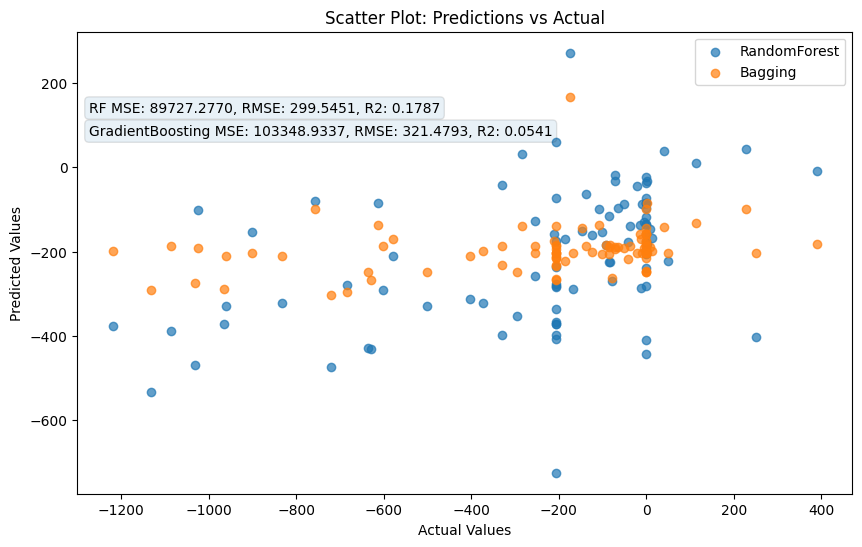

In [ ]:
# Создание графика
plt.figure(figsize=(10, 6))

# Scatter plot для RandomForest
plt.scatter(y_test, y_pred_rf, label='RandomForest', alpha=0.7)

# Scatter plot для GradientBoosting
plt.scatter(y_test, y_pred_gradient_boosting, label='Bagging', alpha=0.7)

# Добавление меток и легенды
plt.title('Scatter Plot: Predictions vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Добавление текста с метриками в углу графика
text_rf = f'RF MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
text_bagging = f'GradientBoosting MSE: {mse_gradient_boosting:.4f}, RMSE: {rmse_gradient_boosting:.4f}, R2: {r2_gradient_boosting:.4f}'

plt.text(0.015, 0.85, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
plt.text(0.015, 0.80, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

# Отображение графика
plt.show()

Видно, что модели имеют очень в разброс значений

Посчитаем стандартное отклонение моделей

In [ ]:
# Рассчитываем стандартное отклонение
std_rf = np.std(y_pred_rf)
std_gradient_boosting = np.std(y_pred_gradient_boosting)
print(f'RandomForest Std: {std_rf:.4f}')
print(f'GradientBoosting Test Std: {std_gradient_boosting:.4f}')

RandomForest Std: 155.5540
GradientBoosting Test Std: 56.4776


Сделаем отдельные графики для каждой модели, добавим линию идельного предсказания и разброса на основе отклонения от фактических и предсказанных

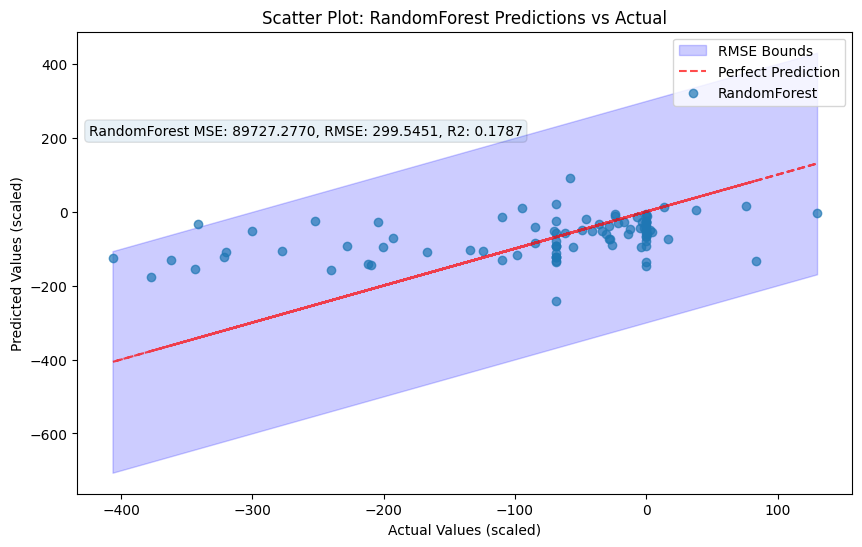

In [ ]:
# Scatter plot для RandomForest
text_rf = f'RandomForest MSE: {mse_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled_rf = y_test / 3
y_pred_rf_scaled = y_pred_rf / 3

# Линия разброса от линии идеального предсказания
lower_bound_rf = np.sort(y_test_scaled_rf - rmse_rf)
upper_bound_rf = np.sort(y_test_scaled_rf + rmse_rf)
plt.fill_between(np.sort(y_test_scaled_rf), lower_bound_rf, upper_bound_rf, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled_rf, y_test_scaled_rf, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled_rf, y_pred_rf_scaled, label='RandomForest', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_rf, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: RandomForest Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

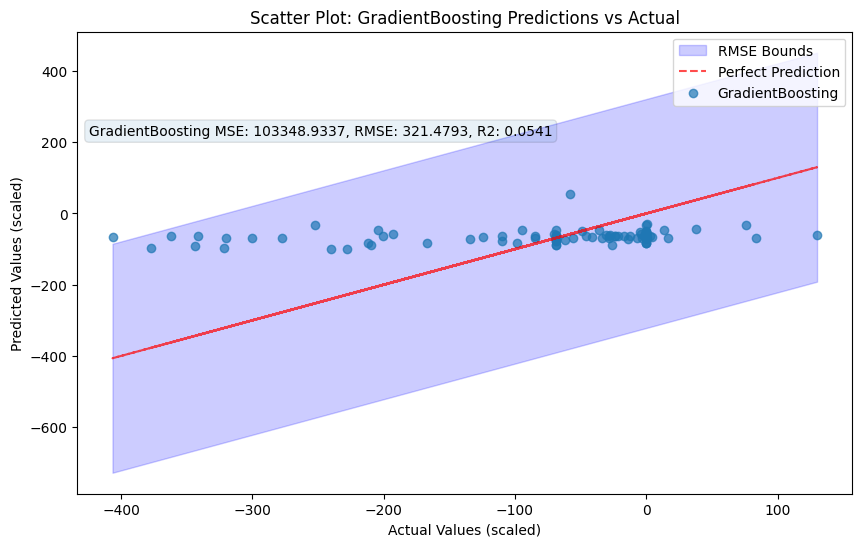

In [ ]:
# График рассеивания для Bagging
text_bagging = f'GradientBoosting MSE: {mse_gradient_boosting:.4f}, RMSE: {rmse_gradient_boosting:.4f}, R2: {r2_gradient_boosting:.4f}'
plt.figure(figsize=(10, 6))

# Уменьшение масштаба по оси Y
y_test_scaled = y_test / 3
y_pred_bagging_scaled = y_pred_gradient_boosting / 3

# Линия разброса от линии идеального предсказания
lower_bound = np.sort(y_test_scaled - rmse_gradient_boosting)
upper_bound = np.sort(y_test_scaled + rmse_gradient_boosting)
plt.fill_between(np.sort(y_test_scaled), lower_bound, upper_bound, color='blue', alpha=0.2, label='RMSE Bounds')

# Идеальная линия предсказания
plt.plot(y_test_scaled, y_test_scaled, label='Perfect Prediction', linestyle='--', color='red', alpha=0.7)

# Точки предсказаний
plt.scatter(y_test_scaled, y_pred_bagging_scaled, label='GradientBoosting', alpha=0.7)

# Добавление текста с метриками
plt.text(0.015, 0.8, text_bagging, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.title('Scatter Plot: GradientBoosting Predictions vs Actual')
plt.xlabel('Actual Values (scaled)')
plt.ylabel('Predicted Values (scaled)')
plt.legend()
plt.show()

# Проверим модели на переобучение

Посмотрим на производительность обучения и разницу визулизаций тестовой и тренировочной выборки

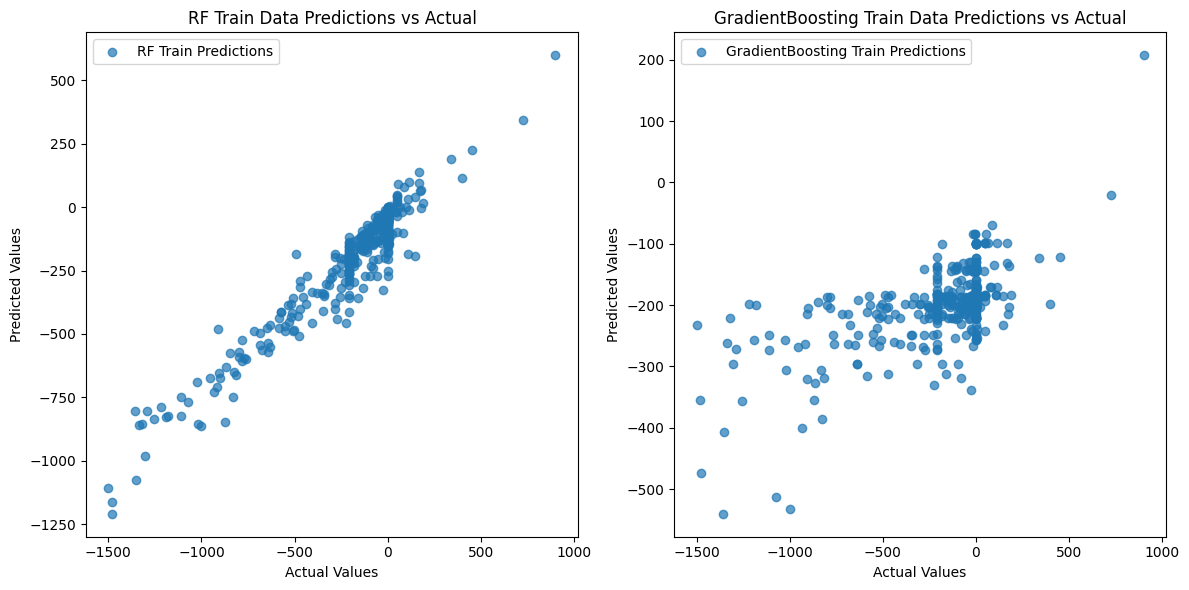

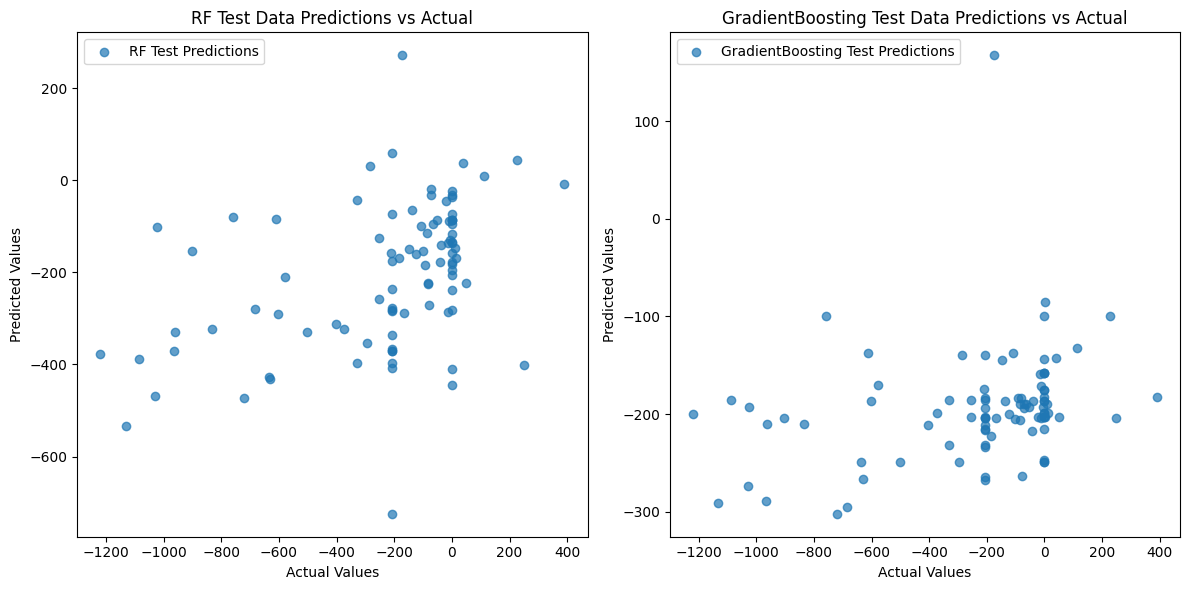

In [ ]:
# Для RandomForest
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

# Для GradientBoosting
y_train_pred_bagging = best_gradient_boosting_model.predict(X_train)
y_test_pred_bagging = best_gradient_boosting_model.predict(X_test)

# Визуализация для тренировочных данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_rf, label='RF Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Train Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_pred_bagging, label='GradientBoosting Train Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoosting Train Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

# Визуализация для тестовых данных
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_rf, label='RF Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RF Test Data Predictions vs Actual')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_bagging, label='GradientBoosting Test Predictions', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('GradientBoosting Test Data Predictions vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_bagging = best_gradient_boosting_model.score(X_train, y_train)
test_accuracy_bagging = best_gradient_boosting_model.score(X_test, y_test)

print(f'RF Train Accuracy: {train_accuracy_rf:.4f}, Test Accuracy: {test_accuracy_rf:.4f}')
print(f'GradientBoosting Train Accuracy: {train_accuracy_bagging:.4f}, Test Accuracy: {test_accuracy_bagging:.4f}')

RF Train Accuracy: 0.8512, Test Accuracy: 0.1787
GradientBoosting Train Accuracy: 0.2034, Test Accuracy: 0.0541


# Интерпретация

Еще раз обучим модели, чтобы иметь возможность обратиться именно к ним

In [ ]:
X = df.drop('exc_bias_oe', axis=1)
y = df['exc_bias_oe']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение RandomForest с заданными гиперпараметрами
rf_params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# Обучение GradientBoosting с заданными гиперпараметрами
gradient_boosting_params = {'n_estimators': 50, 'learning_rate': 0.1, 'max_features': 0.8, 'subsample': 1.0}
gradient_boosting_model = GradientBoostingRegressor(**gradient_boosting_params)
gradient_boosting_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_rf = rf_model.predict(X_test)
y_pred_gradient_boosting = gradient_boosting_model.predict(X_test)

Посмотрим какие данные вносят больший вклад в предсказание с помощью SHAP диаграммы

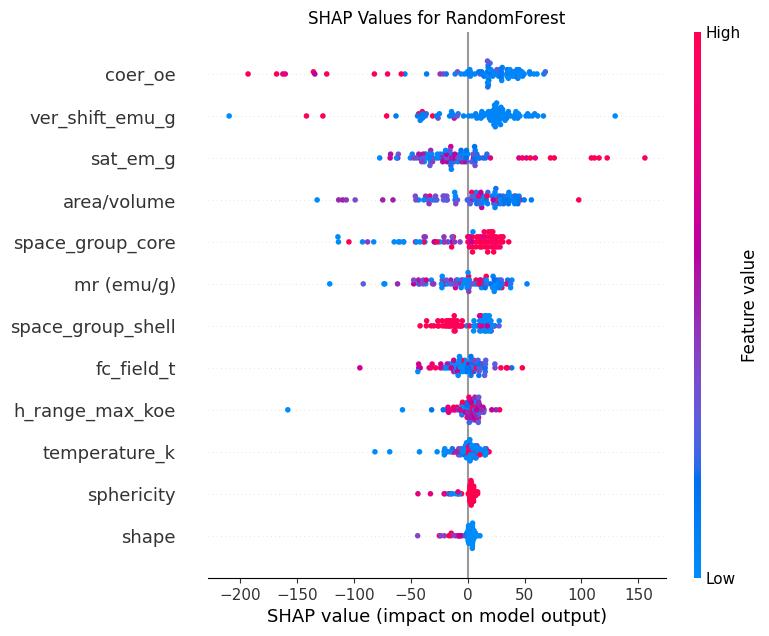

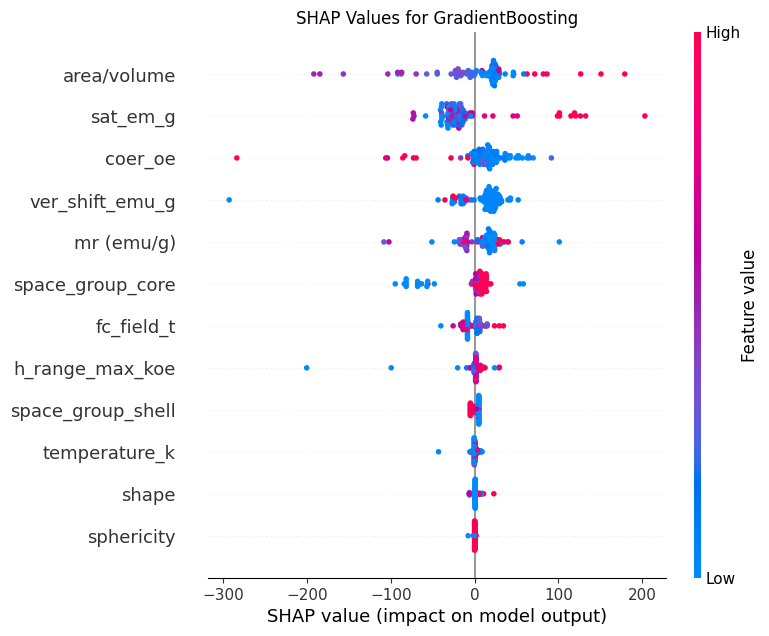

In [ ]:
import shap

# Создание explainer'ов
rf_explainer = shap.TreeExplainer(rf_model)
gradient_boosting_explainer = shap.TreeExplainer(gradient_boosting_model)

# Расчет SHAP-значений для тестового набора данных
shap_values_rf = rf_explainer.shap_values(X_test)
shap_values_gradient_boosting = gradient_boosting_explainer.shap_values(X_test)

# Построение SHAP-диаграммы для RandomForest
shap.summary_plot(shap_values_rf, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for RandomForest')
plt.show()

# Построение SHAP-диаграммы для GradientBoosting
shap.summary_plot(shap_values_gradient_boosting, X_test, feature_names=X_test.columns, show=False)
plt.title('SHAP Values for GradientBoosting')
plt.show()